<a href="https://colab.research.google.com/github/srujanponnur/Balanced_Pruning/blob/master/GAN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.optimizers import Adam
from keras import initializers
from keras.utils import plot_model, np_utils
from keras import backend as K

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


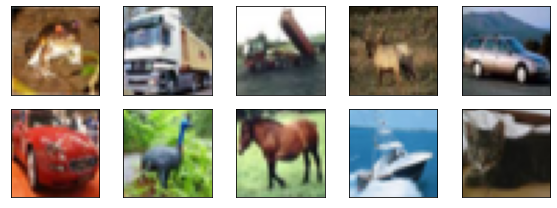

In [ ]:
fig = plt.figure(figsize=(8,3))
for i in range(0, 10):
    plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    plt.imshow(X_train[i])
    
plt.tight_layout()

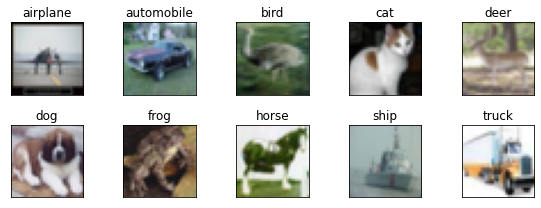

In [ ]:
num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)
    
plt.tight_layout()

In [ ]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)
    
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_train / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

print('X_train reshape:', X_train.shape)
print('X_test reshape:', X_test.shape)

X_train reshape: (50000, 32, 32, 3)
X_test reshape: (50000, 32, 32, 3)


In [ ]:
# latent space dimension
latent_dim = 100

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# FC: 2x2x512
generator.add(Dense(2*2*512, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(Reshape((2, 2, 512)))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# # Conv 1: 4x4x256
generator.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 2: 8x8x128
generator.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 3: 16x16x64
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 4: 32x32x3
generator.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same',
                              activation='tanh'))

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              206848    
                                                                 
 reshape (Reshape)           (None, 2, 2, 512)         0         
                                                                 
 batch_normalization (BatchN  (None, 2, 2, 512)        2048      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2, 2, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 256)        3277056   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 4, 4, 256)        1

In [ ]:
# imagem shape 32x32x3
img_shape = X_train[0].shape

# Discriminator network
discriminator = Sequential()

# Conv 1: 16x16x64
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding='same',
                         input_shape=(img_shape), kernel_initializer=init))
discriminator.add(LeakyReLU(0.2))

# Conv 2:
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
discriminator.add(Conv2D(512, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# FC
discriminator.add(Flatten())

# Output
discriminator.add(Dense(1, activation='sigmoid'))

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         819456    
                                                      

In [ ]:
discriminator.compile(Adam(lr=0.0003, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# d_g = discriminador(generador(z))
discriminator.trainable = False

z = Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = Model(inputs=z, outputs=decision)

d_g.compile(Adam(lr=0.0004, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])

In [ ]:
# prints a summary representation of your model
d_g.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         4516739   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 4312193   
                                                                 
Total params: 8,828,932
Trainable params: 4,514,819
Non-trainable params: 4,314,113
_________________________________________________________________


epoch = 1/100, d_loss=0.163, g_loss=0.030                                                                                                     
1/1 [==============================] - 0s 245ms/step


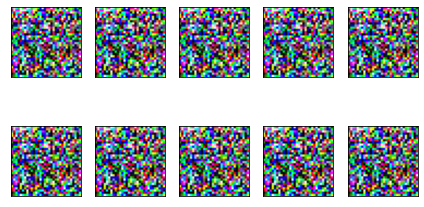

epoch = 2/100, d_loss=0.163, g_loss=0.080                                                                                                     
epoch = 3/100, d_loss=0.163, g_loss=0.096                                                                                                     
epoch = 4/100, d_loss=0.163, g_loss=0.128                                                                                                     
epoch = 5/100, d_loss=0.163, g_loss=0.096                                                                                                     
epoch = 6/100, d_loss=0.164, g_loss=0.143                                                                                                     
epoch = 7/100, d_loss=0.163, g_loss=0.206                                                                                                     
epoch = 8/100, d_loss=0.163, g_loss=0.208                                                                                                     

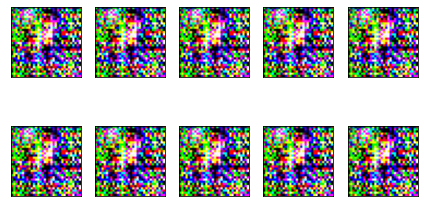

epoch = 12/100, d_loss=0.163, g_loss=0.207                                                                                                     
epoch = 13/100, d_loss=0.163, g_loss=0.236                                                                                                     
epoch = 14/100, d_loss=0.163, g_loss=0.258                                                                                                     
epoch = 15/100, d_loss=0.163, g_loss=0.282                                                                                                     
epoch = 16/100, d_loss=0.163, g_loss=0.261                                                                                                     
epoch = 17/100, d_loss=0.163, g_loss=0.235                                                                                                     
epoch = 18/100, d_loss=0.163, g_loss=0.227                                                                                              

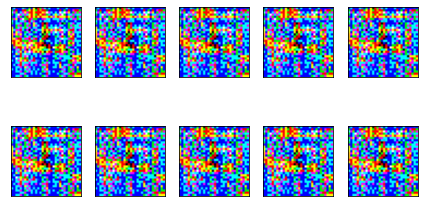

epoch = 22/100, d_loss=0.163, g_loss=0.238                                                                                                     
epoch = 23/100, d_loss=0.163, g_loss=0.236                                                                                                     
epoch = 24/100, d_loss=0.163, g_loss=0.244                                                                                                     
epoch = 25/100, d_loss=0.163, g_loss=0.223                                                                                                     
epoch = 26/100, d_loss=0.163, g_loss=0.235                                                                                                     
epoch = 27/100, d_loss=0.163, g_loss=0.226                                                                                                     
epoch = 28/100, d_loss=0.163, g_loss=0.232                                                                                              

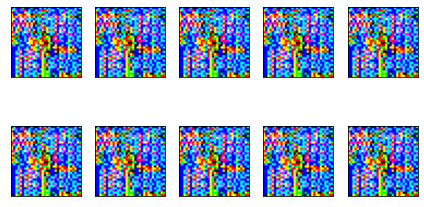

epoch = 32/100, d_loss=0.163, g_loss=0.218                                                                                                     
epoch = 33/100, d_loss=0.163, g_loss=0.214                                                                                                     
epoch = 34/100, d_loss=0.163, g_loss=0.221                                                                                                     
epoch = 35/100, d_loss=0.163, g_loss=0.211                                                                                                     
epoch = 36/100, d_loss=0.163, g_loss=0.223                                                                                                     
epoch = 37/100, d_loss=0.163, g_loss=0.227                                                                                                     
epoch = 38/100, d_loss=0.163, g_loss=0.224                                                                                              

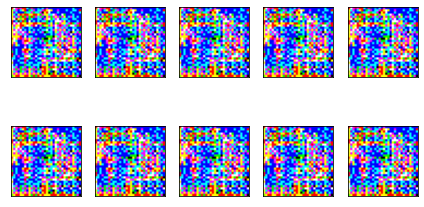

epoch = 42/100, d_loss=0.163, g_loss=0.213                                                                                                     
epoch = 43/100, d_loss=0.163, g_loss=0.205                                                                                                     
epoch = 44/100, d_loss=0.163, g_loss=0.211                                                                                                     
epoch = 45/100, d_loss=0.163, g_loss=0.219                                                                                                     
epoch = 46/100, d_loss=0.163, g_loss=0.215                                                                                                     
epoch = 47/100, d_loss=0.163, g_loss=0.226                                                                                                     
epoch = 48/100, d_loss=0.163, g_loss=0.199                                                                                              

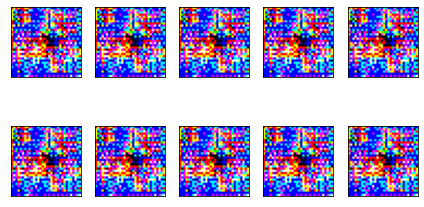

epoch = 52/100, d_loss=0.163, g_loss=0.222                                                                                                     
epoch = 53/100, d_loss=0.163, g_loss=0.216                                                                                                     
epoch = 54/100, d_loss=0.163, g_loss=0.223                                                                                                     
epoch = 55/100, d_loss=0.163, g_loss=0.206                                                                                                     
epoch = 56/100, d_loss=0.163, g_loss=0.219                                                                                                     
epoch = 57/100, d_loss=0.163, g_loss=0.222                                                                                                     
epoch = 58/100, d_loss=0.163, g_loss=0.253                                                                                              

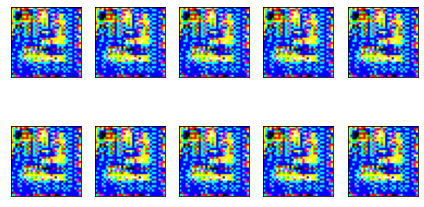

epoch = 62/100, d_loss=0.163, g_loss=0.243                                                                                                     
epoch = 63/100, d_loss=0.163, g_loss=0.241                                                                                                     
epoch = 64/100, d_loss=0.163, g_loss=0.243                                                                                                     
epoch = 65/100, d_loss=0.163, g_loss=0.241                                                                                                     
epoch = 66/100, d_loss=0.163, g_loss=0.215                                                                                                     
epoch = 67/100, d_loss=0.163, g_loss=0.219                                                                                                     
epoch = 68/100, d_loss=0.163, g_loss=0.229                                                                                              

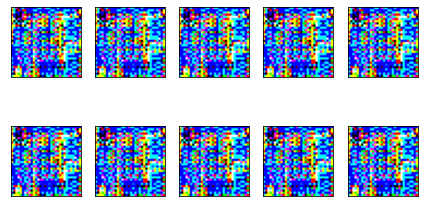

epoch = 72/100, d_loss=0.163, g_loss=0.225                                                                                                     
epoch = 73/100, d_loss=0.163, g_loss=0.223                                                                                                     
epoch = 74/100, d_loss=0.163, g_loss=0.229                                                                                                     
epoch = 75/100, d_loss=0.163, g_loss=0.231                                                                                                     
epoch = 76/100, d_loss=0.163, g_loss=0.231                                                                                                     
epoch = 77/100, d_loss=0.163, g_loss=0.228                                                                                                     
epoch = 78/100, d_loss=0.163, g_loss=0.231                                                                                              

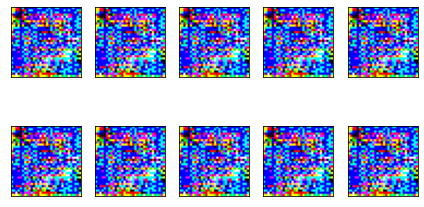

epoch = 82/100, d_loss=0.163, g_loss=0.220                                                                                                     
epoch = 83/100, d_loss=0.163, g_loss=0.224                                                                                                     
epoch = 84/100, d_loss=0.163, g_loss=0.222                                                                                                     
epoch = 85/100, d_loss=0.163, g_loss=0.220                                                                                                     
epoch = 86/100, d_loss=0.163, g_loss=0.224                                                                                                     
epoch = 87/100, d_loss=0.163, g_loss=0.217                                                                                                     
epoch = 88/100, d_loss=0.163, g_loss=0.218                                                                                              

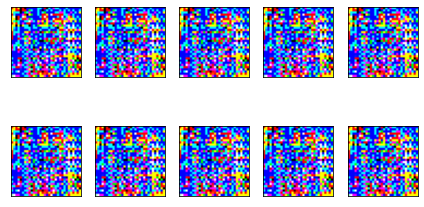

epoch = 92/100, d_loss=0.163, g_loss=0.216                                                                                                     
epoch = 93/100, d_loss=0.163, g_loss=0.222                                                                                                     
epoch = 94/100, d_loss=0.163, g_loss=0.217                                                                                                     
epoch = 95/100, d_loss=0.163, g_loss=0.221                                                                                                     
epoch = 96/100, d_loss=0.163, g_loss=0.216                                                                                                     
epoch = 97/100, d_loss=0.163, g_loss=0.221                                                                                                     
epoch = 98/100, d_loss=0.163, g_loss=0.222                                                                                              

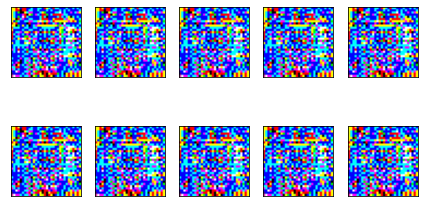

In [ ]:
epochs = 100
batch_size = 32
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        d_loss_real = discriminator.train_on_batch(x=X_batch,
                                                   y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        g_loss_batch = d_g.train_on_batch(x=z, y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
            plt.imshow(((x_fake[k] + 1)* 127).astype(np.uint8))

        plt.tight_layout()
        plt.show()

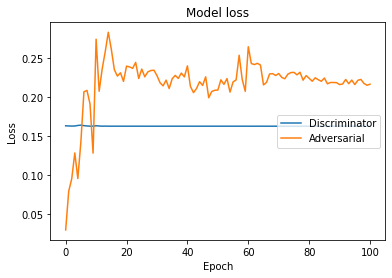

In [ ]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()